In [80]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from basic_functions import *
from cmb import *

# Read the radio galaxy catalog

In [128]:
# path = "./input/sehgal_radio_catalog/radio_short.cat"
path = "./input/sehgal_radio_catalog/radio.cat"

#!!!! Just to make debugging quick, remove for final run!
nObjMax = np.int(1.e7)

data = np.genfromtxt(path)#, max_rows=nObjMax)
ra = data[:,0]  # [deg]
dec = data[:,1]  # [deg]
z = data[:,2]
# f1_4_mJy = data[:,3]  # flux in mJy 
# f30_mJy = data[:,4]  # flux in mJy 
# f90_mJy = data[:,5]  # flux in mJy 
f148_mJy = data[:,6]  # flux in mJy 
# f219_mJy = data[:,7]  # flux in mJy 
# f277_mJy = data[:,8]  # flux in mJy 
# f350_mJy = data[:,9]  # flux in mJy 

## Check localization of sources

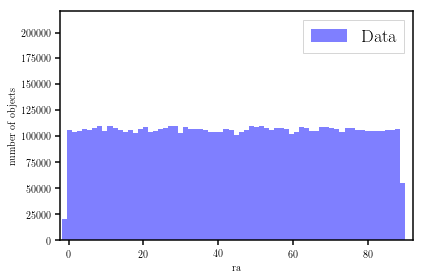

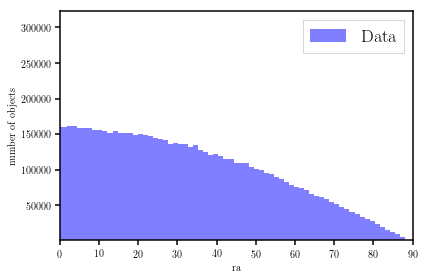

In [129]:
myHistogram(ra, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'ra', semilogx=False, semilogy=False, doGauss=False)
myHistogram(dec, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'ra', semilogx=False, semilogy=False, doGauss=False)

## Check dn/dz of radio sources

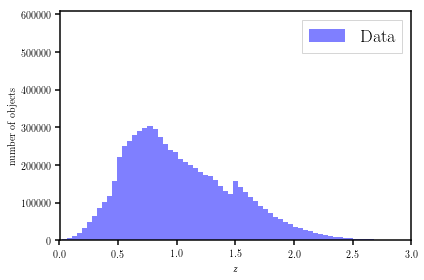

In [130]:
myHistogram(z, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'$z$', semilogx=False, semilogy=False, doGauss=False)


## Check flux distribution

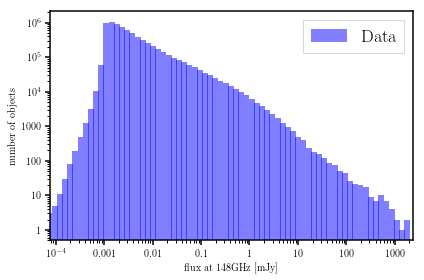

In [131]:
myHistogram(f148_mJy, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'flux at 148GHz [mJy]', semilogx=True, semilogy=True, doGauss=False)


# Generate healpy T, Q, U maps

In [132]:
# print np.min(ra), np.max(ra)
# print np.min(dec), np.max(dec)

In [133]:
# Map geometry to match the Sehgal maps
nSide = 512#4096
nPix = hp.nside2npix(nSide)

# get pixel indices for all galaxies
IPix = hp.ang2pix(nSide, dec*np.pi/180., -ra*np.pi/180., lonlat=True)

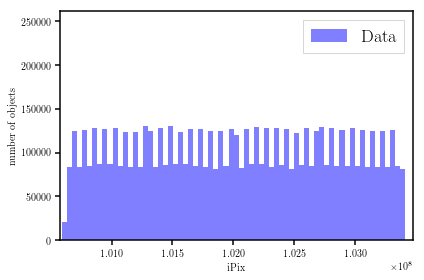

In [140]:
myHistogram(IPix, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'iPix', semilogx=False, semilogy=False, doGauss=False)

In [135]:
# Generate T map
bins = np.arange(nPix+1)-0.5
tMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy, statistic='sum', bins=bins)

## Convert from mJy to Kcmb

In [ ]:
cmb = CMB(beam=1., noise=1., nu1=148.e9, nu2=148.e9, lMin=30., lMaxT=3.e3, lMaxP=5.e3, fg=True, atm=False, name=None)

tMap *= 1.e-3 * 1.e-26  # convert from [mJy] to flux per unit freq = [W/m^2/Hz]
tMap /= hp.nside2pixarea(nSide) # convert from flux per unit freq=[W/m^2/Hz] to surf bright per unit freq = [W/m^2/sr/Hz]
tMap /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from surf bright per unit freq = [W/m^2/sr/Hz] to Kcmb
tMap *= 1.e6  # convert from Kcmb to muKcmb

# The Lambda website says:
# dT = [Jy/sr] * T_CMB / 1.072480e9 in [T_CMB units]
# Check that it works:
#print 1.e-26 / cmb.dBdT(148.e9, cmb.Tcmb), cmb.Tcmb / 1.072480e9

0.0 0.05554126727817419 95689.67957331035 19.038567927303696


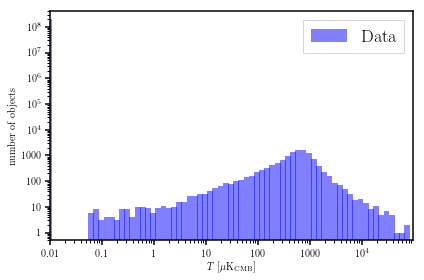

In [141]:
print np.min(tMap), np.mean(tMap), np.max(tMap), np.std(tMap)
myHistogram(1.e-2+tMap, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'$T$ [$\mu$K$_\text{CMB}$]', semilogx=True, semilogy=True, doGauss=False)


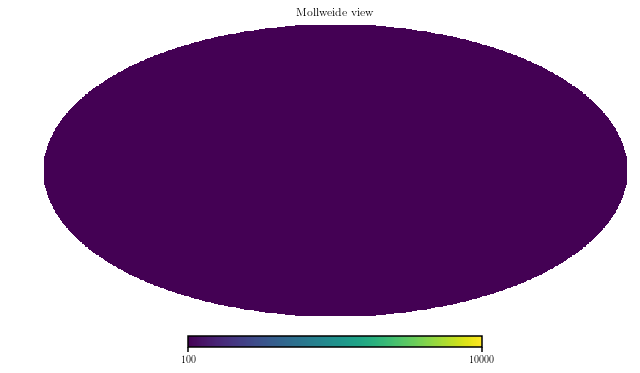

In [143]:
m = np.mean(tMap)
s = np.std(tMap)
hp.mollview(np.log10(1.e-2+tMap), min=1.e2, max=1.e4)

## Rotate from equatorial to Galactic coordinates

In [144]:
rot = hp.Rotator(coord=['C','G'])
tMap = rot.rotate_map_pixel(tMap)

AttributeError: 'Rotator' object has no attribute 'rotate_map_pixel'

# Compare T map to Sehgal radio PS map

# Compare power with Dunkley+13

In [145]:
# Binned power spectrum wrapper for healpy

def powerSpectrum(hMap, mask=None, theory=[], fsCl=None, nBins=51, lRange=None, plot=False, path="./figures/tests/test_power.pdf", save=True):
   """Compute the power spectrum of a healpix map.
   """
   
   nSide = hp.get_nside(hMap)
   if mask is not None:
      hMap *= mask

   # define ell bins
   lMax = 3 * nSide - 1
   if lRange is None:
      lEdges = np.logspace(np.log10(1.), np.log10(lMax), nBins, 10.)
   else:
      lEdges = np.logspace(np.log10(lRange[0]), np.log10(lRange[-1]), nBins, 10.)

   # Unbinned power spectrum
   power = hp.anafast(hMap)
   power = np.nan_to_num(power)

   # corresponding ell values
   ell = np.arange(len(power))

   # Bin the power spectrum
   Cl, lEdges, binIndices = stats.binned_statistic(ell, power, statistic='mean', bins=lEdges)
   
   # correct for fsky from the mask
   if mask is not None:
      fsky = np.sum(mask) / len(mask)
      Cl /= fsky

   # bin centers
   lCen, lEdges, binIndices = stats.binned_statistic(ell, ell, statistic='mean', bins=lEdges)
   # when bin is empty, replace lCen by a naive expectation
   lCenNaive = 0.5*(lEdges[:-1]+lEdges[1:])
   lCen[np.where(np.isnan(lCen))] = lCenNaive[np.where(np.isnan(lCen))]
   # number of modes
   Nmodes, lEdges, binIndices = stats.binned_statistic(ell, 2*ell+1, statistic='sum', bins=lEdges)
   Nmodes = np.nan_to_num(Nmodes)

   # 1sigma uncertainty on Cl
   if fsCl is None:
      sCl = Cl*np.sqrt(2)
   else:
      sCl = np.array(map(fsCl, lCen))
   sCl /= np.sqrt(Nmodes)
   sCl = np.nan_to_num(sCl)

   if plot:
      factor = lCen**2  # 1.
      
      fig=plt.figure(0)
      ax=fig.add_subplot(111)
      #
      ax.errorbar(lCen, factor*Cl, yerr=factor* sCl, c='b', fmt='.')
      ax.errorbar(lCen, -factor*Cl, yerr=factor* sCl, c='r', fmt='.')
      #
      for f in theory:
         L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
         ClExpected = np.array(map(f, L))
         ax.plot(L, L**2 * ClExpected, 'k')
      #
      ax.set_xscale('log', nonposx='clip')
      ax.set_yscale('log', nonposy='clip')
      #ax.set_xlim(1.e1, 4.e4)
      #ax.set_ylim(1.e-5, 2.e5)
      ax.set_xlabel(r'$\ell$')
      #ax.set_ylabel(r'$\ell^2 C_\ell$')
      ax.set_ylabel(r'$C_\ell$')
      #
      if save==True:
         print "saving plot to "+path
         fig.savefig(path, bbox_inches='tight')
#          fig.clf()
      else:
         plt.show()

   return lCen, Cl, sCl

In [ ]:
lCen, Cl, sCl = powerSpectrum(tMap, mask=None, theory=[cmb.fradioPoisson], fsCl=None, nBins=101, lRange=None, plot=True, path="", save=False)


In [ ]:
cl = hp.anafast(tMap)

plt.loglog(np.arange(len(cl)), cl)
plt.show()

# Extract cutouts

In [ ]:
# position (lon, lat, psi) of the cutout center
lon = 0. * np.pi/180.  # [deg] to [rad]
lat = 0. * np.pi/180.  # [deg] to [rad]
pos = (lon, lat, 0.) 

# map side in lon and lat
lonRange = 10. * np.pi/180. # [deg] to [rad]
latRange = 10. * np.pi/180. # [deg] to [rad]
pixRes = 0.5 * np.pi/180./60.  # [arcmin] to [rad]

# number of pixels on the side
xSize = np.ceil(lonRange / pixRes)
ySize = np.ceil(latRange / pixRes)

# extract cutout map
cutMap = hp.visufunc.cartview(tMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True)